<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Predicting House Prices in Ames, Iowa

## Problem Statement

The goal of this project is to build a linear regression model that can predict the selling price of houses across Ames, Iowa. Additionally, this project aims to provide insights on:

1. Which particular neighborhoods in Ames are most profitable?
2. Which particular type of properties in Ames are most profitable?
3. Which features are most important to renovate in order to maximize returns on a property? 

### Contents:
1. [Background](#1.-Background)
2. [Data Cleaning](#2.-Data-Cleaning)
3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
4. [Data Pre-Processing](#4.-Data-Pre-Processing)
5. [Data Modeling](#5.-Data-Modeling)
6. [Kaggle Submissions](#6.-Kaggle-Submissions)
7. [Conclusions and Recommendations](#7.-Conclusions-and-Recommendations)

## 1. Background

Opendoor Technologies Inc is a digital platform for transacting in residential real estate headquarterd in San Fracisco. Opendoor aims to reinvent the real estate experience through making it possible to buy and sell property on a mobile device.

Opendoor has created a new model for selling a home, called iBuying. To summarize the business model, property owners can bid to sell their properties through the Opendoor app or website. Opendoor will purchase the property as-is, and then make necessary repairs before relisting the property. More information on Opendoor and their business model can be found [here](https://www.opendoor.com/w/faq/what-is-opendoor).

Opendoor currently offers their services to 27 markets in the US, and is now looking to expand their service to Iowa. As part of their market analysis, Opendoor would like to do a case study on the housing market in Ames, Iowa. 

Using historical data from the Ames Assesor's Office on individual properties sold in Ames from 2006-2010, Opendoor has tasked their data science team to build a model that can be used to predict the selling price of various houses across Ames, Iowa. More information on the dataset can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

Opendoor will use this model as a benchmark to assess whether to accept a bid for a property based on a property's features. In addition, Opendoor would like to know:
1. Which particular neighborhoods in Ames are most profitable?
2. Which particular type of residential properties in Ames are most profitable?
2. Which features should Opendoor focus on renovating to maximize their returns when re-listing the properties?

## 2. Data Cleaning

In [1]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn import metrics

import statsmodels.api as sm
from scipy import stats

In [2]:
# import dataset
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')


# add columns to identify train and test set
train['set'] = 'train'
test['set'] = 'test'

# combine train and test set for data cleaning
df = pd.concat([train,test])

In [3]:
# train set size
train.shape

(2051, 82)

In [4]:
# test set size
test.shape

(878, 81)

In [5]:
# display first 5 rows
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,set
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,train
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,train
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,train
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,174000.0,train
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,138500.0,train


In [6]:
# check shape
df.shape

(2929, 82)

In [7]:
# check which features have missing values
df.columns[df.isnull().any()]

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature', 'SalePrice'],
      dtype='object')

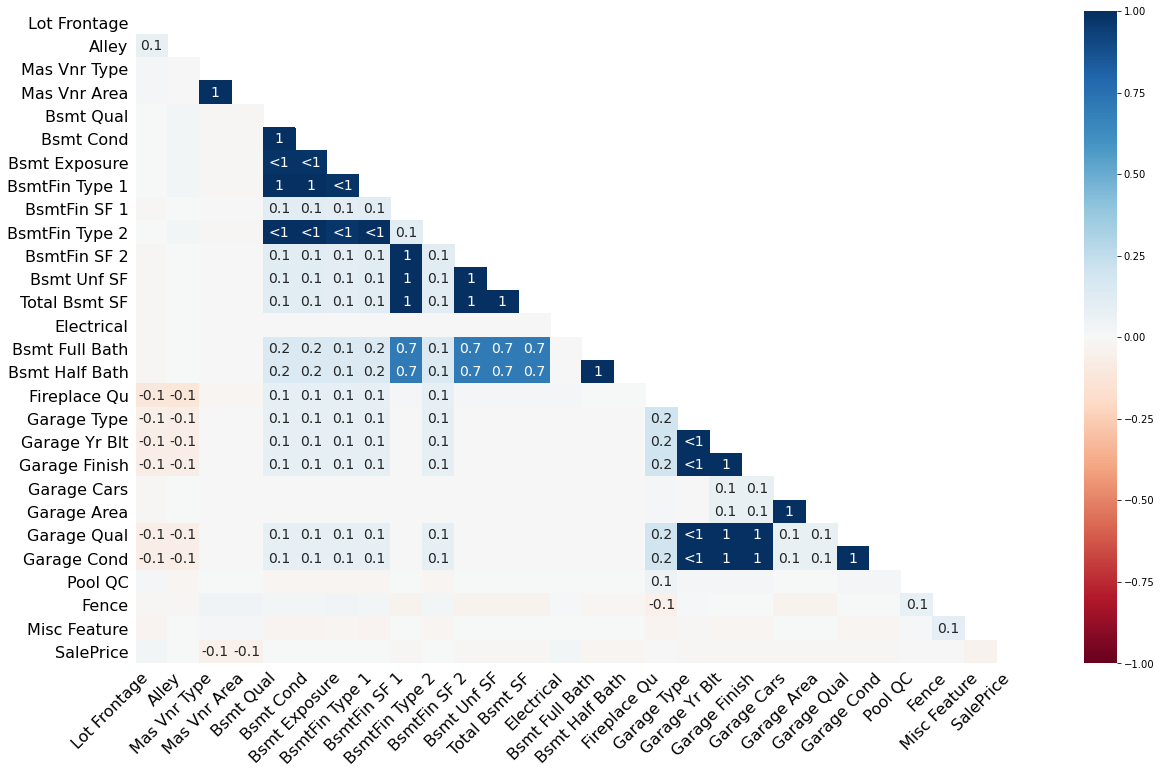

In [8]:
# see missing feature correlation
msno.heatmap(df);

- From the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)- many of the missing values can be interpreted as "None" i.e. the house does not have this feature
- Many of the missing features are correlated - if a house does not have a garage, it will not have data for the year built, area, quality of the garage etc.

In [9]:
# basement features
bsmt_feat = ['Id','Bsmt Qual','Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF','Bsmt Full Bath',
       'Bsmt Half Bath','set']

In [10]:
df[(df['Bsmt Exposure'].isnull()) & (df['Bsmt Qual'].notnull())][bsmt_feat]

,Id,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,set
1456,1797,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0,train
1547,67,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0,train
1997,2780,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0,train


- From data dictionary, for Bsmt Exposure "Nan" means no basement while "No" means no exposure. The three instances above most likely do have basements, but do not have basement exposure => update the null values to "No" instead.

In [11]:
# update null Bsmt Exposure values to "No" exposure
df['Bsmt Exposure'] = np.where((df['Bsmt Exposure'].isnull()) & (df['Bsmt Qual'].notnull()), "No", df['Bsmt Exposure'])

In [12]:
df[(df['BsmtFin Type 2'].isnull()) & (df['BsmtFin Type 1'].notnull())][bsmt_feat]

,Id,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,set
1147,445,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0,train


- From data dictionary, for BsmtFin Type 2 "Nan" means no basement. The instance above does have a basement, but we do not know the quality. Since it is only 1 instance I will drop the row.

In [13]:
# drop row Id 445
df = df[df['Id'] != 445]

In [14]:
# based on data dictionary => impute '.' for features where NA means the feature is not available, 0 for numeric data
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [15]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [16]:
# check year features
df[['Year Built', 'Year Remod/Add', 'Yr Sold', 'Garage Yr Blt']].describe()

,Year Built,Year Remod/Add,Yr Sold,Garage Yr Blt
count,2928.000000,2928.000000,2928.000000,2928.000000
mean,1971.333333,1984.251708,2007.790301,1870.695014
std,30.242854,20.859606,1.316792,449.033697
min,1872.000000,1950.000000,2006.000000,0.000000
25%,1954.000000,1965.000000,2007.000000,1957.000000
50%,1973.000000,1993.000000,2008.000000,1977.000000
75%,2001.000000,2004.000000,2009.000000,2001.000000
max,2010.000000,2010.000000,2010.000000,2207.000000


- There is a garage built in the year 2207. The data is only until 2010, so no year info should be past this date 

In [17]:
df[df['Garage Yr Blt']>2010]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,set
1699,2261,916384070,20,RL,68.0,8298,Pave,.,IR1,HLS,...,0,.,.,.,0,9,2007,New,267300.0,train


In [18]:
df = df[df['Garage Yr Blt']<=2010] # delete row where garage built in year 2207

In [19]:
# garage features
garage_feat = ['Id','Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 
               'Garage Area', 'Garage Qual','Garage Cond','set']

In [20]:
# check for garage yr blt = 0 there is no garage in the property
df[(df['Garage Yr Blt'] == 0) & (df['Garage Type'] != '.')][garage_feat]

,Id,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,set
1712,2237,Detchd,0.0,.,0.0,0.0,.,.,train
764,1357,Detchd,0.0,.,1.0,360.0,.,.,test


- For Id 2237 all features except garage type are empty - I will assume the detchd is incorrect and update the garage type to no garage
- For Id 1357 there is a garage area, so garage most likely does exist. I will update the Garage Yr Blt to the House Yr Blt

In [21]:
df['Garage Type'] = np.where(df['Id']==2237, '.', df['Garage Type'])
df['Garage Yr Blt'] = np.where(df['Id'] == 1357, df['Year Built'], df['Garage Yr Blt'])

In [22]:
# check data type
df.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice       float64
set              object
Length: 82, dtype: object

In [23]:
# Some categorical features are treated as int => should convert them to strings instead
string_feat = ['Id', 'PID', 'MS SubClass']
for feat in string_feat:
    df[feat] = df[feat].apply(str)

In [24]:
# several ordinal columns are treated as categorical 
# => convert these to numbers to be in line with the Overall Qual and Overal Cond modeling
ordinal_dict = {"Lot Shape" : {"Reg" : 0, "IR1" : 1, "IR2": 2, "IR3":3 },
                "Utlities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub":4},
                "Land Slope": {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                "Exter Qual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Exter Cond": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Bsmt Qual": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Bsmt Cond": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Bsmt Exposure": {".":0, "No":1, "Mn":2, "Av":3, "Gd":4},
                "BsmtFin Type 1": {".": 0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ":4, "ALQ":5, "GLQ":6},
                "BsmtFin Type 2": {".": 0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ":4, "ALQ":5, "GLQ":6},
                "Heating QC": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Electrical": {"Mix":0, "FuseP":1, "FuseF":2, "FuseA":3, "SBrkr":4},
                "Kitchen Qual": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Functional": {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8},
                "Fireplace Qu": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Pool QC": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Garage Finish": {".":0, "Unf":1, "RFn":2, "Fin":3},
                "Garage Qual": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Garage Cond": {".":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex": 5},
                "Paved Drive" :{"N":1, "P": 2, "Y": 3}}

df = df.replace(ordinal_dict)

In [25]:
# check shape
df.shape

(2927, 82)

In [26]:
# update train and test df to use for EDA

df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

In [27]:
df_test.shape

(878, 81)

In [28]:
df_train.shape

(2049, 81)

## 3. Exploratory Data Analysis

### 3.1 Univariate Analysis

In [29]:
# statistics summary for sale price (target variable)
df_train['SalePrice'].describe()

count      2049.000000
mean     181377.773548
std       79242.231175
min       12789.000000
25%      129800.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

- min value is 13k USD and max value is 612k USD, which is not unreasonable for house sale prices (and no negative values for sale price which looks correct)

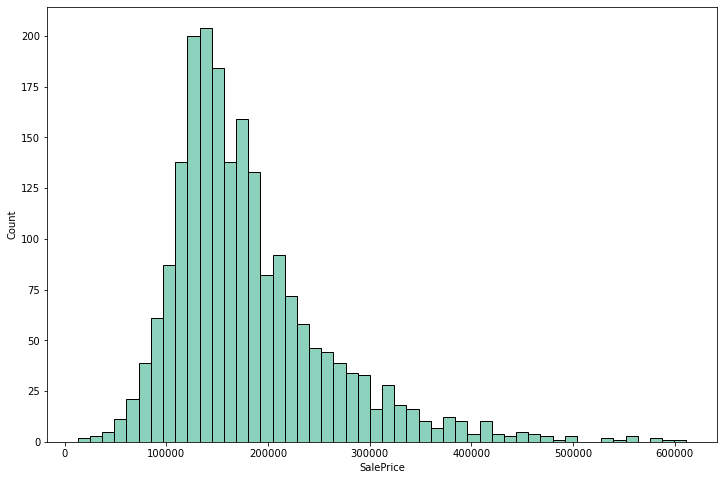

In [30]:
# Plot histogram
sns.set_palette("Set2")
plt.figure(figsize=(12,8))
sns.histplot(df[df['set']=='train']['SalePrice'],bins=50);

In [31]:
# check skew and kutosis
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 0.632123
Kurtosis: 0.619548


- data is not normally distributed
- data is positively skewed
- I may consider a log transformation to normalize the sale price distribution for modeling purposes

### 3.2 Multivariate Analysis (Features correlation)

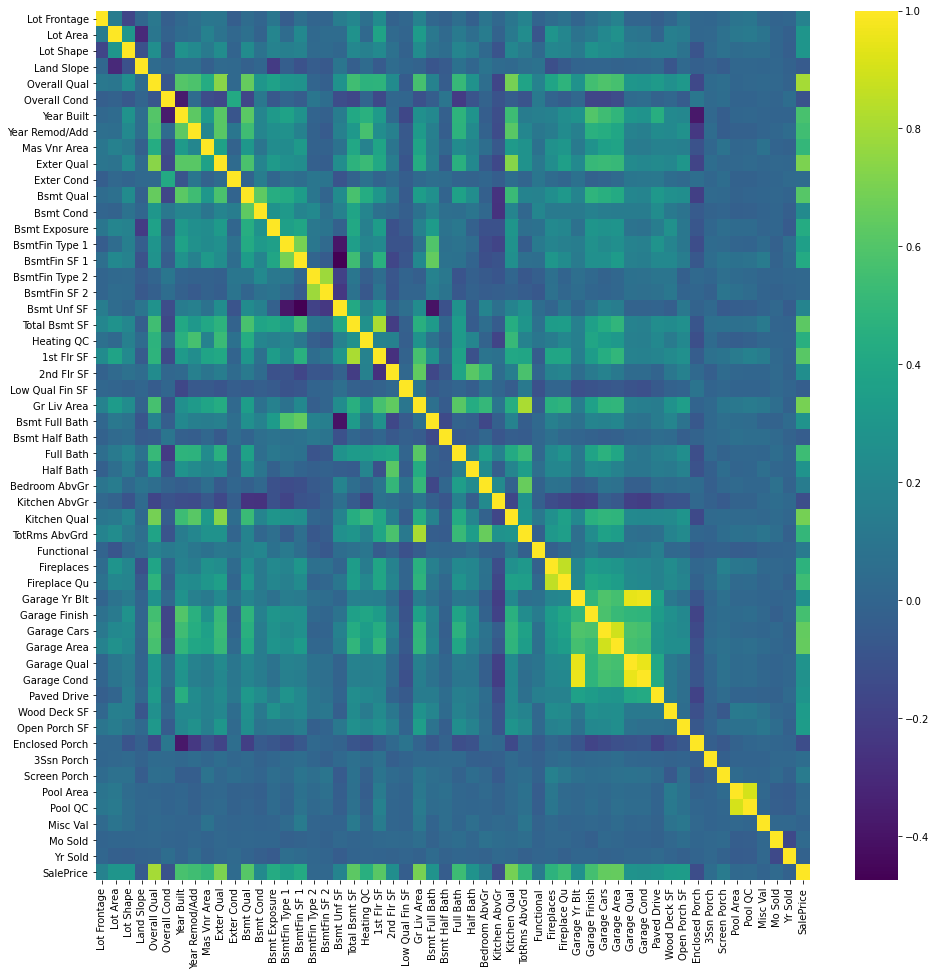

In [32]:
#Correlation matrix heatmap
plt.figure(figsize=(16,16))
sns.heatmap(df_train.corr(), cmap="viridis");

- There are a lot of features => I will look at the top 20 features most correlated with my target variable in depth first

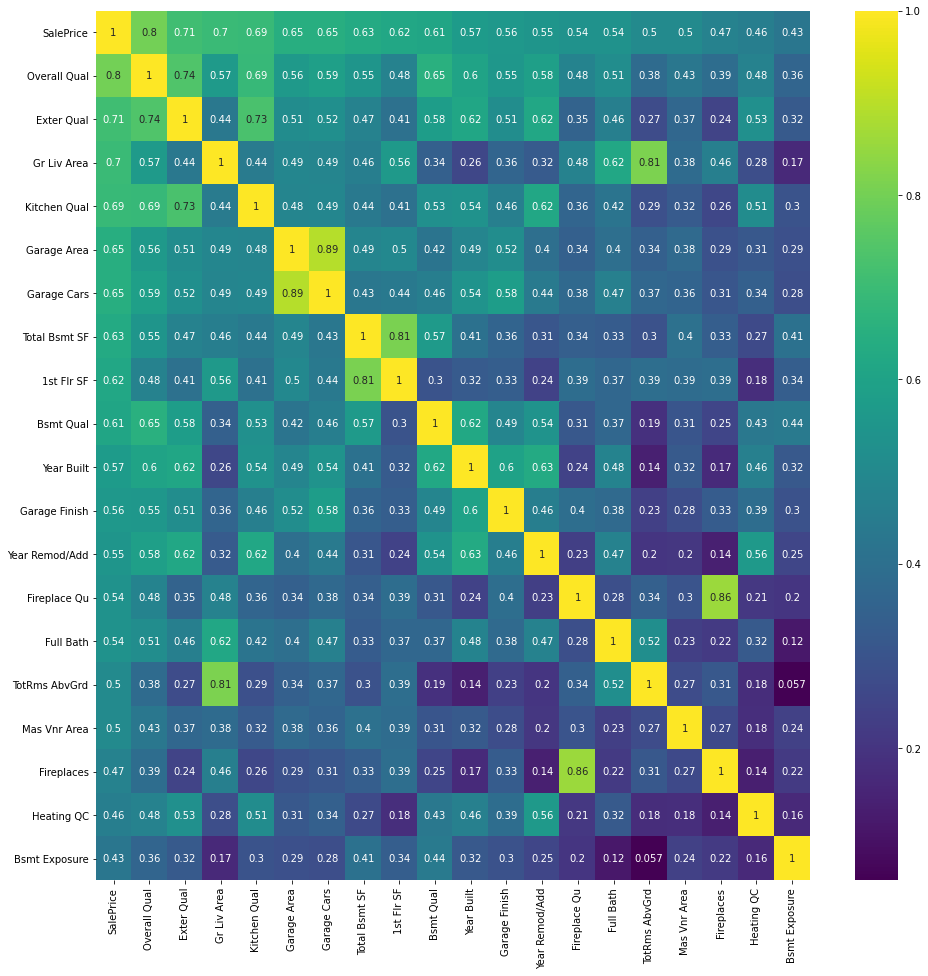

In [33]:
#Sale price correlation matrix heatmap - top 20 features most correlated with Sale Price
plt.figure(figsize=(16,16))
sns.heatmap(df_train[abs(df_train.corr()).nlargest(20, 'SalePrice').index].corr(),annot=True, cmap="viridis");

- For Sale Price, the features that have the highest correlation are Overall Quality and Gr Liv Area => let's explore this
- There are many features that have a high correlation and are essentially providing the same information => I will consider dropping some of these features where the correlation coefficient is high:
> - Overall Qual, Exter Qual, and Kitchen Qual
> - Gr Liv Area and TotRms AbvGrd
> - Total Bsmt SF and 1st Flr SF
> - Garage Area and Garage Cars
> - Fireplaces and Fireplace Qu

#### Overall Quality vs Sale Price

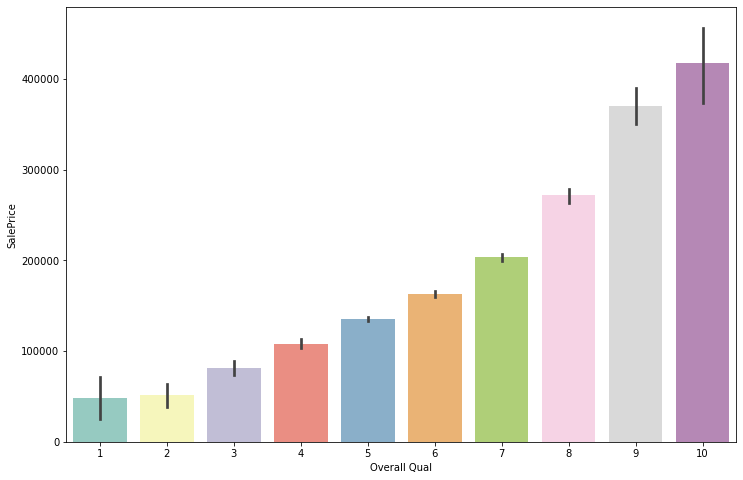

In [34]:
sns.set_palette('Set3')
plt.figure(figsize=(12,8))
sns.barplot(data= df_train, x = 'Overall Qual', y = 'SalePrice');

- As expected, when the overall quality of the house increases, the sale price will also increase. 
- There does seem to be a linear relationship between the overall quality and sale price => I will consider treating ordinal features as continuous rather than categorical featues for modeling

#### Gr Liv Area vs Sale Price

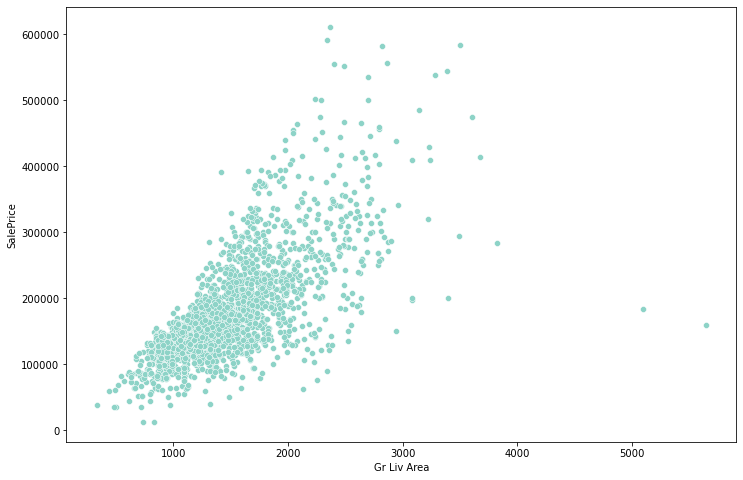

In [35]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_train, x='Gr Liv Area', y = 'SalePrice');

- There are 2 outliers where the area is above 4000 square feet, but the sale price is much lower that what I would expect

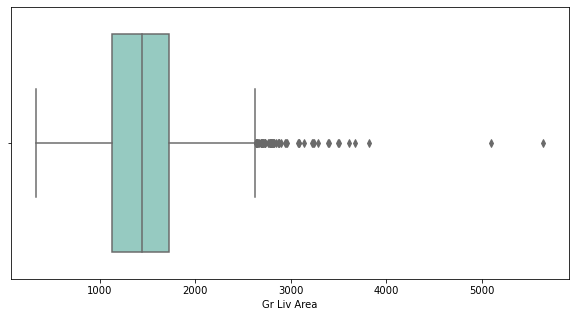

In [36]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df_train, x = 'Gr Liv Area');

- There are two outliers above 4000 square feet are visible in the box plot as well => I will drop these two instances

In [37]:
df[(df['Gr Liv Area']>4000) & (df['set']=='train')]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,set
960,1499,908154235,60,RL,313.0,63887,Pave,.,3,Bnk,...,480,4,.,.,0,1,2008,New,160000.0,train
1885,2181,908154195,20,RL,128.0,39290,Pave,.,1,Bnk,...,0,0,.,Elev,17000,10,2007,New,183850.0,train


In [38]:
df = df[(df['Id'] != '1499') & (df['Id'] != '2181')]

df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

#### Sale Price Vs Year Built/Remodelled

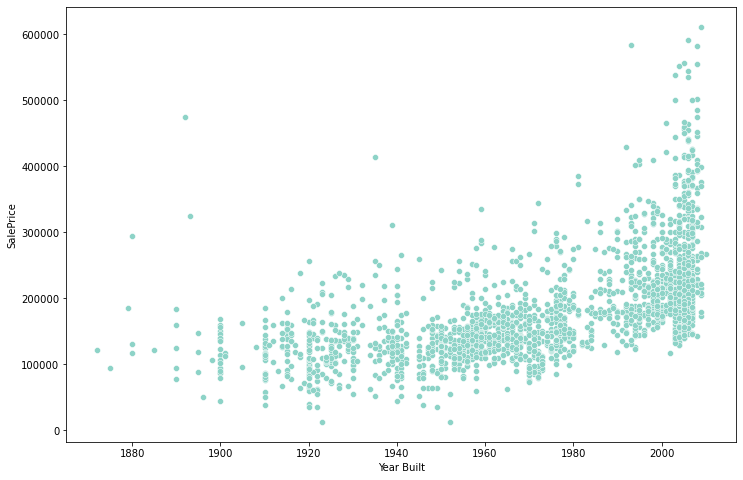

In [39]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = df_train, x = 'Year Built', y = 'SalePrice');

- Can see there is a correlation between the year the house was built and the sale price. To make this easier for analysis, I will create a new feature for the age of the house when it was sold (i.e. the year the house was sold minus the year the house was built).

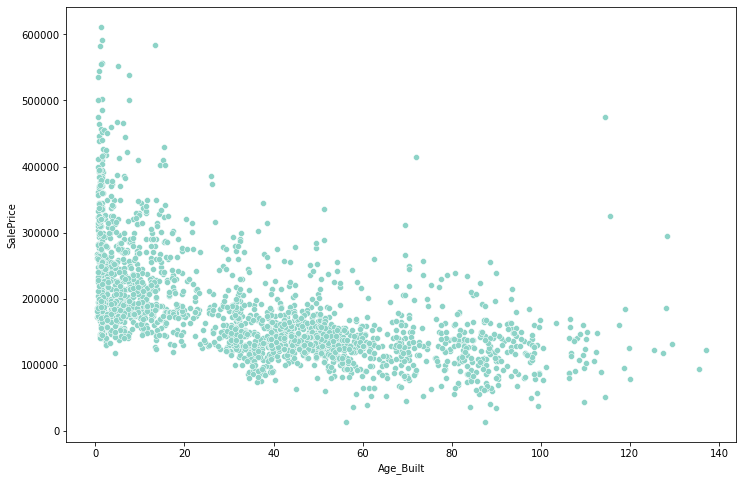

In [40]:
df['Age_Built'] = df['Yr Sold'] + (df['Mo Sold']/12) - df['Year Built']

df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)



plt.figure(figsize=(12,8))
sns.scatterplot(data = df_train, x = 'Age_Built', y = 'SalePrice');

- The scatter plot for age is, as expected, the opposite for the scatter plot of year built (i.e. the smaller the age, the higher the sale price).
- I will create a similar feature for the age of the house from when it was last remodelled to when it was sold

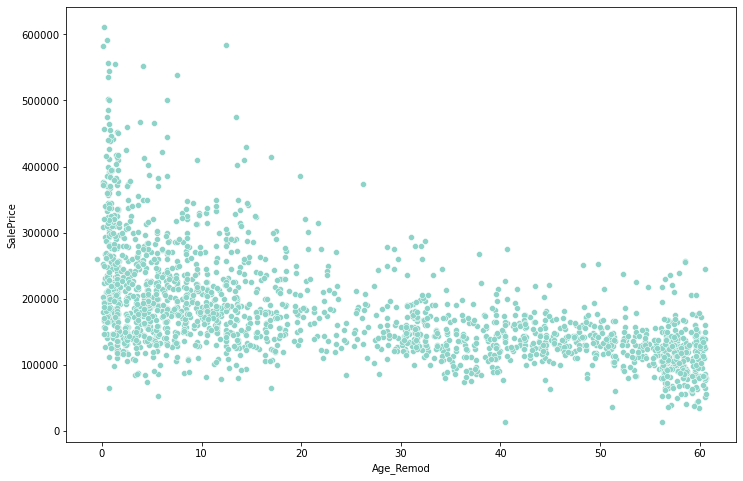

In [41]:
df['Age_Remod'] = df['Yr Sold'] + (df['Mo Sold']/12) - df['Year Remod/Add']


df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

plt.figure(figsize=(12,8))
sns.scatterplot(data = df_train, x = 'Age_Remod', y = 'SalePrice');

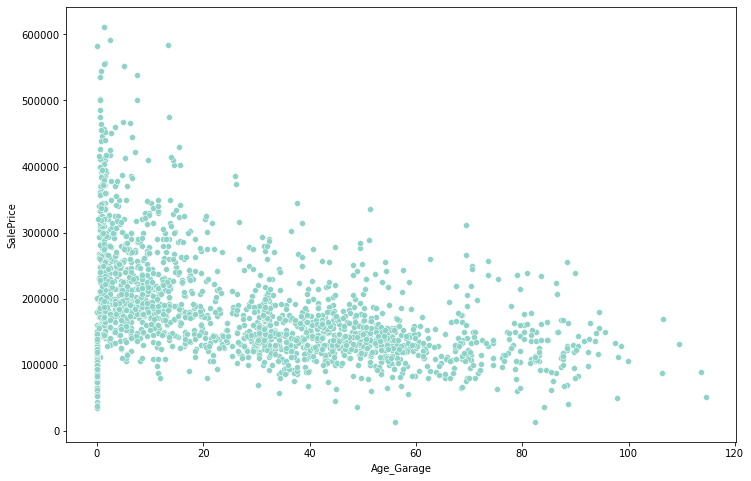

In [42]:
def convert_garage(row):
    if row['Garage Type'] == '.':
        return 0
    else:
        return row['Yr Sold'] + (row['Mo Sold']/12) - row['Garage Yr Blt']

df['Age_Garage'] = df.apply(lambda row: convert_garage(row), axis=1)


df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)


plt.figure(figsize=(12,8))
sns.scatterplot(data = df_train, x = 'Age_Garage', y = 'SalePrice');

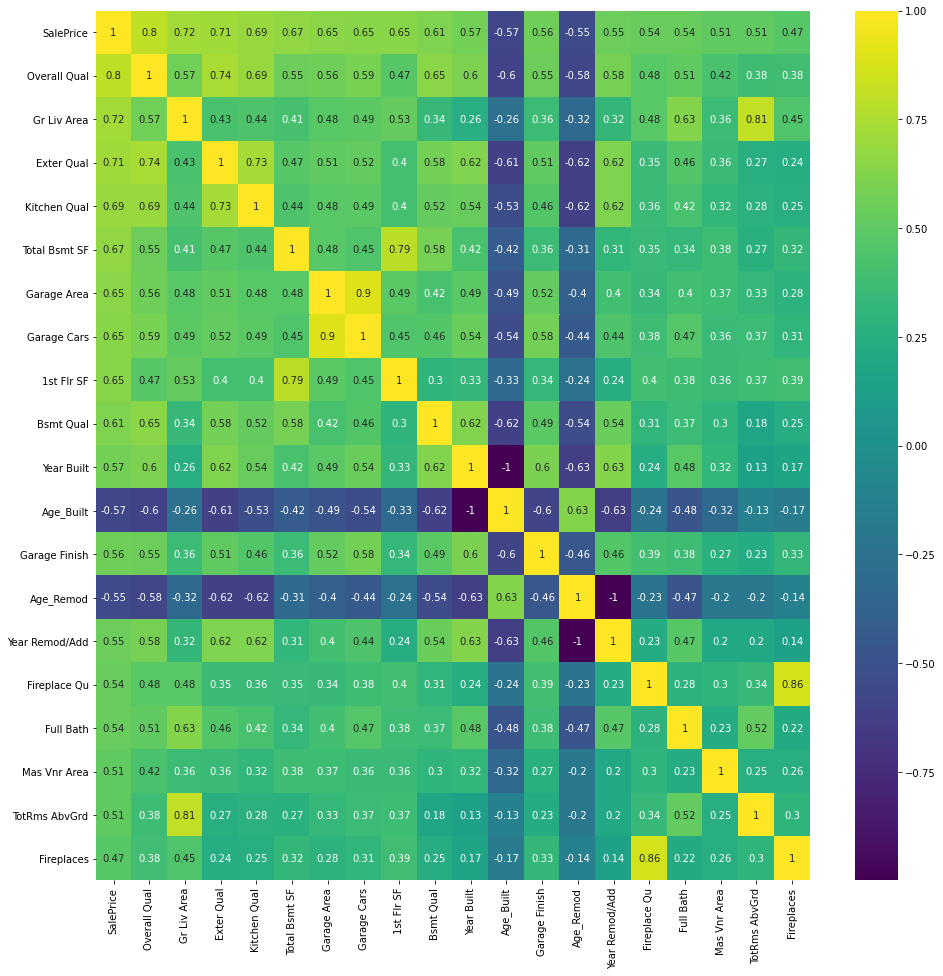

In [43]:
#Sale price correlation matrix heatmap - top 20 features most correlated with Sale Price
plt.figure(figsize=(16,16))
sns.heatmap(df_train[abs(df_train.corr()).nlargest(20, 'SalePrice').index].corr(),annot=True, cmap="viridis");

- Looking at the correlation matrix again with the additional features - can see there is a strong correlation between the Age Built/Year Built and Age_Remod/Year_Remod features => I will drop the Year features and keep the new age features instead. 

In [44]:
# check features for high correlation 
np.abs(df_train.corr()).unstack().sort_values(ascending=False).drop_duplicates()[:20]

Age_Garage      Age_Garage        1.000000
Age_Built       Year Built        0.999075
Year Remod/Add  Age_Remod         0.998092
Garage Yr Blt   Garage Cond       0.954930
Garage Cond     Garage Qual       0.950486
Garage Yr Blt   Garage Qual       0.947659
Pool QC         Pool Area         0.898498
Garage Area     Garage Cars       0.897180
Fireplaces      Fireplace Qu      0.860824
TotRms AbvGrd   Gr Liv Area       0.812159
SalePrice       Overall Qual      0.803171
1st Flr SF      Total Bsmt SF     0.792312
BsmtFin Type 2  BsmtFin SF 2      0.781109
Overall Qual    Exter Qual        0.738059
Exter Qual      Kitchen Qual      0.728928
BsmtFin SF 1    BsmtFin Type 1    0.722853
SalePrice       Gr Liv Area       0.719732
Exter Qual      SalePrice         0.714726
Age_Garage      Age_Built         0.696128
                Year Built        0.694688
dtype: float64

<AxesSubplot:>

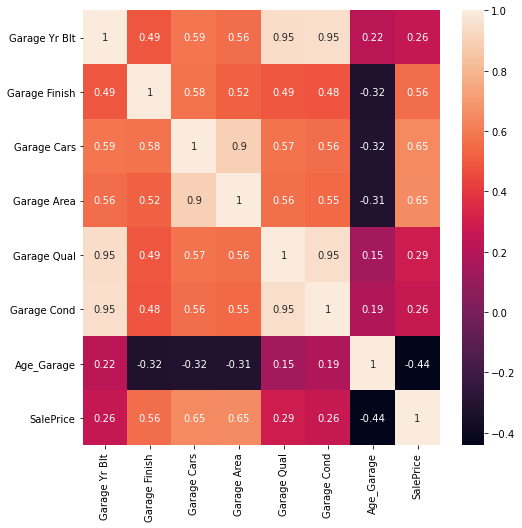

In [45]:
# many garage features seem highly correlated - lets look at garage features and sale price heatmap
garage_feat.remove('set')
garage_feat.extend(['Age_Garage', 'SalePrice'])

plt.figure(figsize = (8,8))
sns.heatmap(df_train[garage_feat].corr(), annot = True)

In [46]:
# drop features with high correlation (above 0.8), as well as PID feature
df.drop(["PID",
         "Year Built", 
         "Year Remod/Add", 
         "Garage Yr Blt",
         "Garage Cond",
         "Pool Area",
         "Garage Cars",
         "Fireplaces",
         "TotRms AbvGrd"
        ],axis=1,inplace=True)

df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

In [47]:
# check remaining features for high correlation 
np.abs(df_train.corr()).unstack().sort_values(ascending=False).drop_duplicates()[:20]

Age_Garage      Age_Garage        1.000000
Overall Qual    SalePrice         0.803171
Total Bsmt SF   1st Flr SF        0.792312
BsmtFin SF 2    BsmtFin Type 2    0.781109
Exter Qual      Overall Qual      0.738059
Kitchen Qual    Exter Qual        0.728928
BsmtFin Type 1  BsmtFin SF 1      0.722853
Gr Liv Area     SalePrice         0.719732
Exter Qual      SalePrice         0.714726
Age_Built       Age_Garage        0.696128
Kitchen Qual    SalePrice         0.694072
                Overall Qual      0.688476
SalePrice       Total Bsmt SF     0.666150
BsmtFin SF 1    Bsmt Full Bath    0.657292
Gr Liv Area     2nd Flr SF        0.656230
SalePrice       Garage Area       0.654860
Overall Qual    Bsmt Qual         0.652807
SalePrice       1st Flr SF        0.647779
Bsmt Qual       Bsmt Cond         0.632565
Gr Liv Area     Full Bath         0.630503
dtype: float64

#### Year Sold vs Sale Price

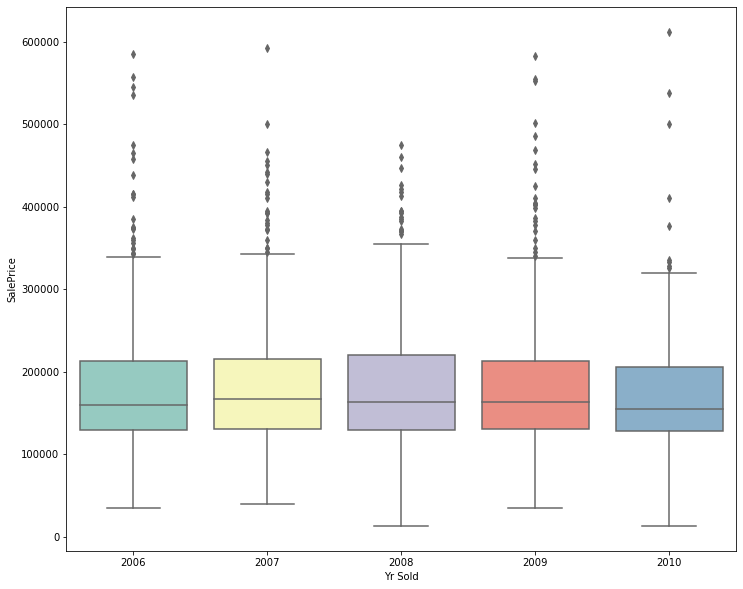

In [48]:
plt.figure(figsize=(12,10))
sns.boxplot(x = df_train['Yr Sold'], y = df_train['SalePrice']);

In [49]:
df_train.groupby('Yr Sold').describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Yr Sold,,,,,,,,
2006,438.0,179471.609589,81906.247408,35000.0,129575.0,159250.0,213342.5,584500.0
2007,496.0,185363.020161,77208.446658,39300.0,130000.0,167000.0,215250.0,591587.0
2008,434.0,181800.488479,77470.580228,13100.0,129500.0,163000.0,219701.5,475000.0
2009,445.0,182227.053933,81832.524749,34900.0,129900.0,163000.0,213000.0,582933.0
2010,234.0,174180.059829,77047.778280,12789.0,128000.0,155000.0,206000.0,611657.0


- Although it seems the median sale price is similar across the 5 years, 2008 does seem to have a significantly lower minimum and maximum sale price.  and there does seem to be some variations in the distributions of sale prices depending on the years. 
- I don't want my model to be too reliant on the year sold, because the purpose is to predict the sale price of new houses. In this case, I will create a seperate feature to identify houses sold in 2008, and drop the Yr sold feature.
- The count for 2010 is significantly lower => the dataset must not be for the full year 

In [50]:
# group data by month sold for 2010
df_train[df_train['Yr Sold']==2010].groupby('Mo Sold').describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Mo Sold,,,,,,,,
1,16.0,188805.625000,73366.212549,97500.0,147962.5,184890.5,208500.0,376162.0
2,21.0,176564.285714,63894.735978,96000.0,122000.0,160000.0,214000.0,319900.0
3,35.0,182650.200000,99972.338975,76000.0,131250.0,153000.0,205250.0,611657.0
4,52.0,161531.807692,58563.220187,68400.0,125875.0,149900.0,182000.0,328000.0
5,53.0,187433.358491,68007.814292,76500.0,134800.0,185500.0,222500.0,335000.0
6,53.0,167896.509434,89172.756791,12789.0,128000.0,149900.0,189000.0,538000.0
7,4.0,101125.000000,40579.910876,55000.0,73750.0,103750.0,131125.0,142000.0


- The dataset is only up to the start of July 2010

#### Month Sold vs Sale Price

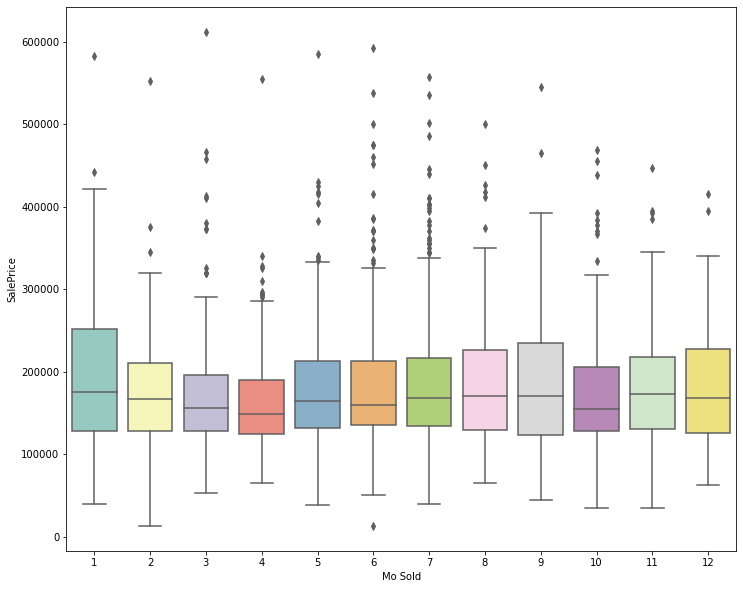

In [51]:
plt.figure(figsize=(12,10))
sns.boxplot(x = df_train['Mo Sold'], y = df_train['SalePrice']);

- There does seem to be a component of seasonality here - The median sale prices are lowest for March, April and October, and highest for January and November. 

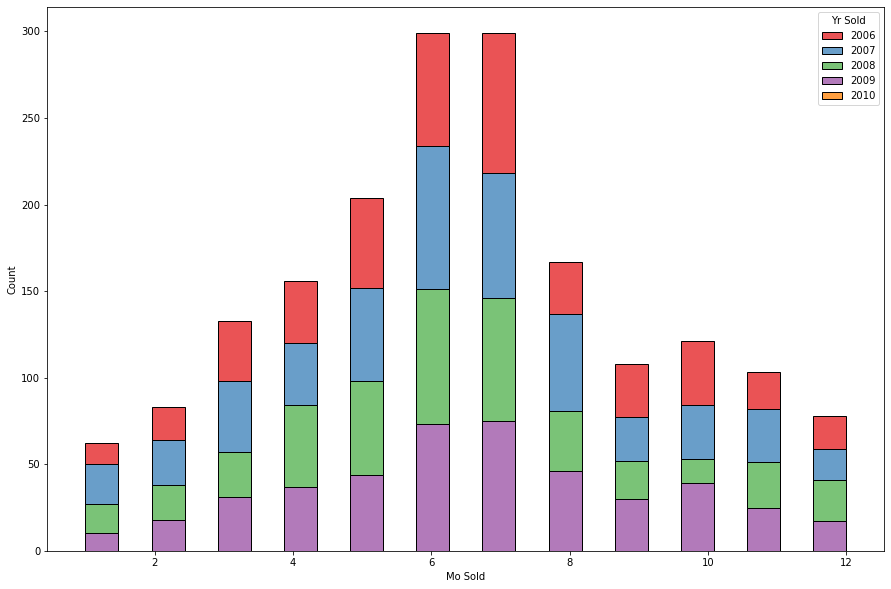

In [52]:
plt.figure(figsize=(15,10))
sns.histplot(x = df_train[df_train['Yr Sold']!=2010]['Mo Sold'], 
             hue = df_train['Yr Sold'], 
             palette='Set1', multiple="stack"); #exclude 2010 as I do not have full year data

In [53]:
df_train[df_train['Yr Sold'] != 2010].groupby('Mo Sold').count()['SalePrice']

Mo Sold
1      62
2      83
3     133
4     156
5     204
6     299
7     299
8     167
9     108
10    121
11    103
12     78
Name: SalePrice, dtype: int64

- More houses are sold in the summer months, and fewer houses are sold in the winter months
- Lets group the months by seasons

In [54]:
# change data type for Month sold to string seasons
df['seasons'] = df['Mo Sold'].map({1:'winter',
                                   2:'winter',
                                   3: 'spring',
                                   4: 'spring',
                                   5: 'summer',
                                   6: 'summer',
                                   7: 'summer',
                                   8: 'autumn',
                                   9: 'autumn',
                                   10: 'autumn',
                                   11: 'winter',
                                   12: 'winter' 
                                  })

In [55]:
# add feature to identify houses sold in 2008 and drop Yr sold feature
df['is_2008'] = df['Yr Sold'].apply(lambda x: 1 if x==2008 else 0)

In [56]:
# drop year sold and month sold columns
df.drop(['Yr Sold', 'Mo Sold'], axis = 1, inplace=True)

In [57]:
# updata train and test sets
df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

## 4. Data Pre-Processing 

### 4.1 Log Transformation of Sale Price

- From univariable study on sale price, data is positively skewed and not normally distributed
- I will use log transformation to normalize the sale price distribution as a normalized target variable may perform better

In [58]:
df['SalePrice'] = np.log1p(df['SalePrice'])

df_train = df[df['set']=='train'].drop('set',axis=1)
df_test = df[df['set']=='test'].drop('set', axis = 1)

In [59]:
# mean and std for normalized log Sale Price

(mu, sigma) = stats.norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 12.02 and sigma = 0.41



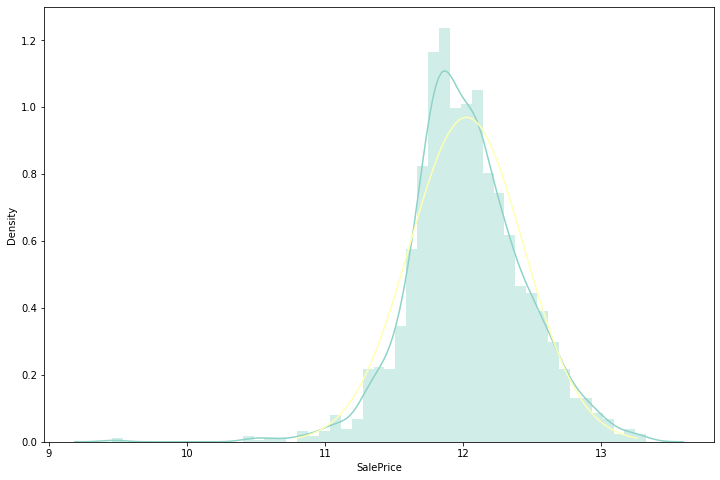

In [60]:
# plot log Sale Price to see if distribution is normalized

plt.figure(figsize=(12,8))
sns.distplot(df_train['SalePrice'])

normdist = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(normdist, stats.norm.pdf(normdist, mu, sigma));

In [61]:
# check skew and kutosis
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: -0.859778
Kurtosis: -1.243413


- The data is less skewed than the original sale price
- The data is more similar to the normal distribution bell curve

### 4.2 Dummy Variables for Categorical features

In [62]:
# create dummy variables for all categorical features (remove set and Id features from data set)
df = pd.get_dummies(df.drop(['set','Id'],axis=1), drop_first=True)

In [63]:
df.shape

(2925, 223)

In [64]:
# split test and train datasets
df_train = df[:2047]
df_test = df[2047:].drop('SalePrice',axis=1)

### 4.3 Train/Test Split

- Create train test split only using the train dataframe. 
- The test dataframe (which does not contain any sale prices) will be used to predict prices for Kaggle submission after I evaluate and select my best linear regression model

In [65]:
# create train test split 
X = df_train.drop('SalePrice', axis = 1)
y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=103)

### 4.4 Standardize Features

In [66]:
# instantiate standard scaler
sc = StandardScaler()

# fit standard scaler on train set
X_train_sc = sc.fit_transform(X_train)

# transform test set and kaggle submission set
X_test_sc = sc.transform(X_test)
test_submission = sc.transform(df_test)

## 5. Data Modeling

- I will train multiple models including a baseline model, Linear regression (with no regularization), Ridge regression and Lasso regression models
- To evaluate my models, I will compare the R2 scores for my train, test, and cross validation sets. This will allow me to see if my models are overfitting or underfitting, and make adjustments
- I will also compare the R2 score and RMSE score for my test data for each model to compare how well my models perform on new data 

In [67]:
# functions for comparing models 

# RMSE function
def rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse.mean())

#compare train, test, and cv score
def display_r2(model, X_train, y_train, X_test, y_test):
    print('Train Score: ', round(model.score(X_train,y_train),7))
    print('Test Score: ', round(model.score(X_test, y_test),7))
    print('Cross Val Score:', round(cross_val_score(model, X_test,y_test).mean(),7))

# model comparisons
model_dictionary = {}
def add_model(name, model, X_test, y_test):
    model_dictionary[name] = [round(rmse(model,X_test,y_test),7), #RMSE
                              round(model.score(X_test, y_test),7)] #r2 score
    return pd.DataFrame.from_dict(model_dictionary, orient = 'index', columns=['RMSE', 'R2 Score'])
    
# Plot Residuals and Predictions
def plot_pred(model, X_test, y_test):
    pred = model.predict(X_test)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot Residuals
    ax1.set_title('Residuals Plot')
    ax1.set(xlabel='Predicted values', ylabel='Residuals')
    ax1.scatter(pred, y_test - pred)
    ax1.hlines(y = 0, xmin = min(pred), xmax = max(pred), colors='red', linestyles='solid')
    
    #Plot Predictions
    ax2.set_title('Predictions vs Actuals')
    ax2.set(xlabel='Predicted values', ylabel='Actual Values')
    ax2.scatter(pred, y_test)
    
    lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]
    
    ax2.plot(lims, lims, 'k-', c = 'red', zorder=0)
                              
    plt.show()

### 5.1 Naive/Baseline 

- My baseline model is the prediction I would use if I had no data for the houses except the sale price. 
- In this case, I will use the mean sale price as a prediction for the selling price of any house

In [68]:
mean_yhat = y_train.mean()

In [69]:
# Create dataframe of actual and predicted sale price for test set
baseline = pd.DataFrame(y_test)
baseline['yhat'] = mean_yhat

In [70]:
# Calculate RMSE for test set
print('RMSE :',(np.mean(np.square(np.expm1(y_test) - np.expm1(mean_yhat)) ** 0.5)))

#Calculate r2 score
print('r2 score:', metrics.r2_score(baseline['SalePrice'], baseline['yhat']))

RMSE : 56374.821049088976
r2 score: -0.0014689474063680485


In [71]:
model_dictionary = {'Baseline': [np.mean(np.square(y_test - mean_yhat)) ** 0.5, #RMSE
                                 metrics.r2_score(baseline['SalePrice'], baseline['yhat'])]} #r2 Score

### 5.2 Linear Regression Model (No Regularization)

In [72]:
# instantiate linear regression 
lm = LinearRegression()

# fit linear regression model on train data
lm.fit(X_train_sc,y_train)

LinearRegression()

In [73]:
# compare train, test, cv scores
display_r2(lm, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9410908
Test Score:  -4.3934179865256575e+19
Cross Val Score: -7.067202780780927e+23


- model performed well on test set, but performed very poorly on the test and cv sets
- model is extremely overfitted, likely because of the high number of features

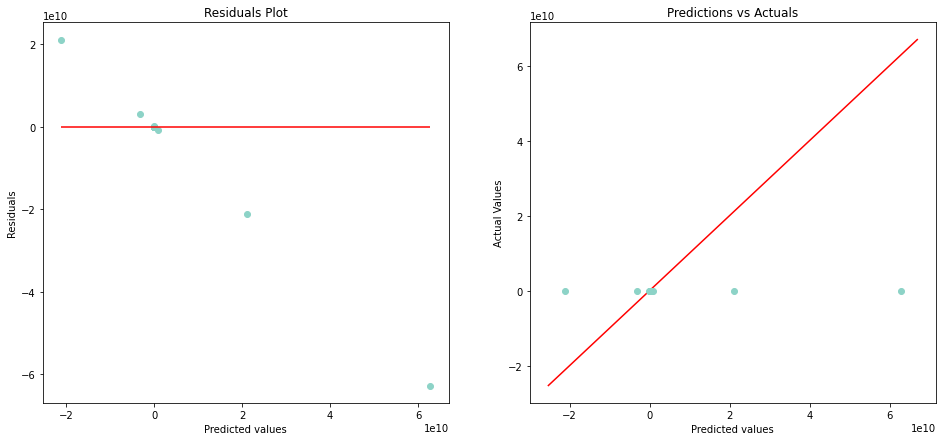

In [74]:
# plot residuals and prediction vs actual
plot_pred(lm, X_test_sc, y_test)

- From the graphs, the predicted values are very different from actual values
- The residuals are linear => if the model performed well, the residuals would be random and symmetrically distributed

In [75]:
# add model for comparison
add_model('LinReg Default', lm, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19


- The linear regression model is scoring worse than the baseline on test data
- Let's add regularization to reduce the variance in the model

### 5.3 Ridge Regression (Default Parameters)

In [76]:
# instantiate ridge
rm = Ridge()

# fit ridge to train data
rm.fit(X_train_sc,y_train)

Ridge()

In [77]:
# compare train, test, cv scores

display_r2(rm, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9403418
Test Score:  0.9032528
Cross Val Score: 0.8819624


- Ridge regression performs much better than the linear regression or basline model, even when using the default parameter for alpha
- There is still some overfitting as the test and cv scores are lower than the train score

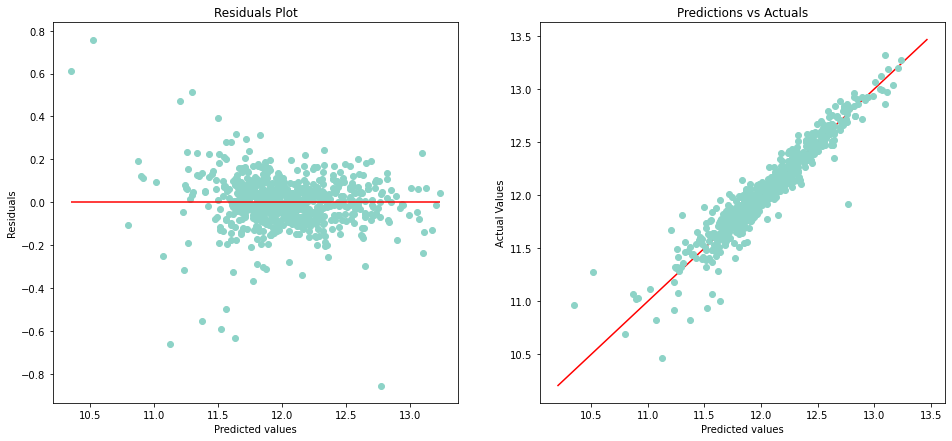

In [78]:
# plot residuals and prediction vs actual

plot_pred(rm, X_test_sc, y_test)

- The actual and predicted values in the graph look much more aligned. However, it can be seen that the model works betst for higher sale prices, as the data points are further from the red line for smaller values
- The residuals show a similar funnel effect - the model shows less error for higher values compared to lower values

In [79]:
# add model for comparison

add_model('Ridge Default', rm, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19
Ridge Default,1.375318e-01,9.032528e-01


- The ridge model has by far performed the best so far, as the RMSE value is much smaller than the baseline, and the R2 score is 0.90325 compared with negative R2 scores for the baseline and linear regression (with no regularization) models

### 5.4 Lasso Regression (Default Parameters)

In [80]:
# instantiate lasso
lasm = Lasso()
lasm.fit(X_train_sc, y_train)

Lasso()

In [81]:
# compare train, test, cv scores

display_r2(lasm, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.0
Test Score:  -0.0014689
Cross Val Score: -0.0084443


- The default lasso model does not work well for this case. The train, test and cross validation score are extremely low 
- The model has high bias and is underfitting the data

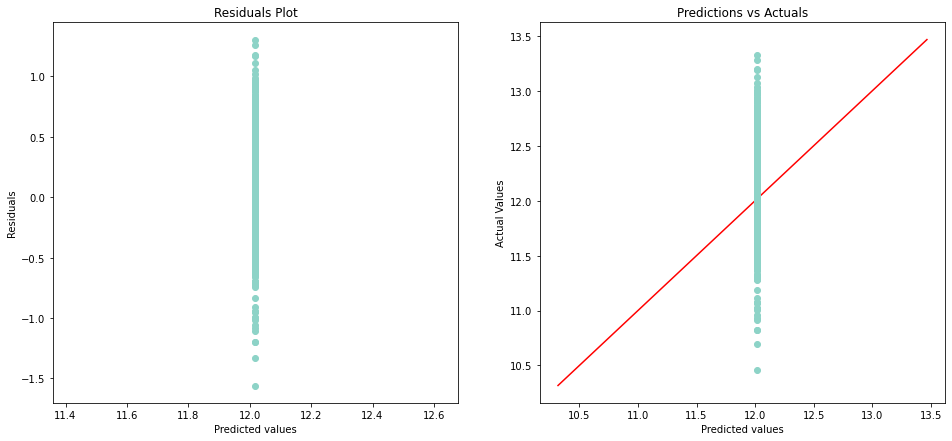

In [82]:
# plot residuals and prediction vs actual

plot_pred(lasm, X_test_sc, y_test)

- Both graphs show that the model is underfitting. The model predicts a similar value for all instances which is similar to the baseline, where the model will predict the mean price regardless of any additional data

In [83]:
# add model for comparison

add_model('Lasso Default', lasm, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19
Ridge Default,1.375318e-01,9.032528e-01
Lasso Default,4.039333e-01,-1.468900e-03


- So far, the ridge model is still performing the best
- The default lasso model performs almost the same as the baseline model

### 5.5 Ridge Regression (with Hyperparameter Tuning)

In [84]:
# choose values of alpha to train
r_alphas = np.logspace(0, 5, 100)

# instantiate ridgeCV
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# fit ridgeCV to train data
ridge_cv = ridge_cv.fit(X_train_sc, y_train)

In [85]:
# store best value for alpha

ridge_a = ridge_cv.alpha_

In [86]:
#instantiate ridge with best value for alpha
ridge_tuned = Ridge(alpha = ridge_a )

#fit ridge to train data
ridge_tuned.fit(X_train_sc, y_train)

Ridge(alpha=187.3817422860383)

In [87]:
# compare train, test, cv scores

display_r2(ridge_tuned, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9300239
Test Score:  0.9217659
Cross Val Score: 0.9131847


- With hyperparameter tuning, the ridge model performs even better
- The train, test, and cv scores are very similar and show significantly less overfitting than previous models

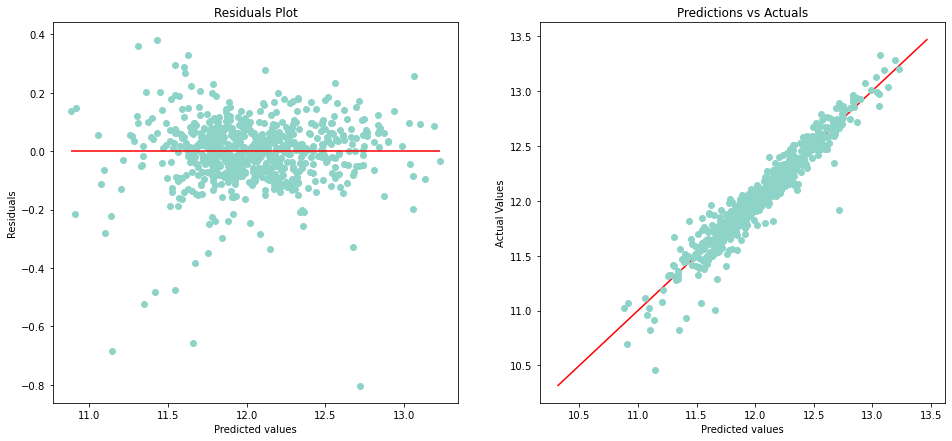

In [88]:
# plot residuals and prediction vs actual

plot_pred(ridge_tuned, X_test_sc, y_test)

- The predictions vs actuals graph shows relatively accurate predictions
- The residuals graph looks unbiased, although there still seems to be a slight funneling effect (i.e. the model still predicts better on higher values)
- From the residuals, it can also be seen that there are more extreme negative residuals, which means the predicted values are higher than the actuals

In [89]:
# add model for comparison

add_model('Ridge with Hyperparameter Tuning', ridge_tuned, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19
Ridge Default,1.375318e-01,9.032528e-01
Lasso Default,4.039333e-01,-1.468900e-03
Ridge with Hyperparameter Tuning,1.180445e-01,9.217659e-01


- The ridge model with hyperparameter tuning has the lowest RMSE score and the highest R2 score. This model is by far the best performing model in comparison, followed by the default ridge model

### 5.6 Lasso Regression (with Hyperparameter Tuning)

In [90]:
# choose values of alpha to train
l_alphas = np.logspace(-3, 0, 100)

# instantiate lassoCV
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=80000)

# fit lassoCV to train data
lasso_cv.fit(X_train_sc, y_train);

In [91]:
# store best value for alpha
lasso_a = lasso_cv.alpha_

In [92]:
# instantiate lasso with new alpha
lasso_tuned = Lasso(alpha = lasso_a )

# fit lasso to train data
lasso_tuned.fit(X_train_sc, y_train)

Lasso(alpha=0.004037017258596553)

In [93]:
# compare train, test, cv scores

display_r2(lasso_tuned, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9231379
Test Score:  0.9241969
Cross Val Score: 0.9232465


- This model performs very similarly on train, test, and cross validation data
- This model is a good fit

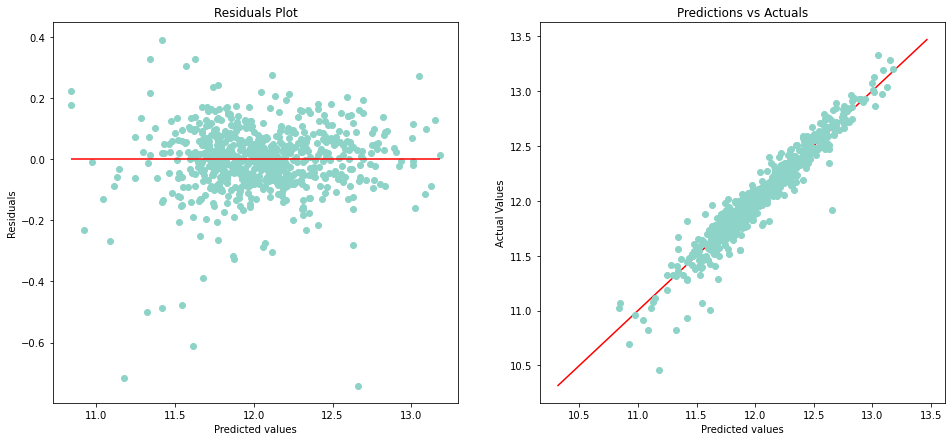

In [94]:
# plot residuals and prediction vs actual

plot_pred(lasso_tuned, X_test_sc, y_test)

- The graphs for this model look very similar to the ridge model with hyperparamter tuning (i.e. the predictions seem better for higher values, and for the more extreme residuals the predicted value tends to be lower than the actuals)

In [95]:
# add model for comparison

add_model('Lasso with Hyperparameter Tuning', lasso_tuned, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19
Ridge Default,1.375318e-01,9.032528e-01
Lasso Default,4.039333e-01,-1.468900e-03
Ridge with Hyperparameter Tuning,1.180445e-01,9.217659e-01
Lasso with Hyperparameter Tuning,1.108917e-01,9.241969e-01


- Lasso with hyperparamter tuning is the best model so far. This model performed significantly better than the lasso model with default parameters.
- This model performed even better than the ridge model with hyperparamter tuning.
- I am satisfied with the performance of this model => I will check how many features this lasso model has eliminated, as well as the features this model considers important

In [96]:
coef = pd.Series(lasso_tuned.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) +  
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 83 variables and eliminated the other 139 variables


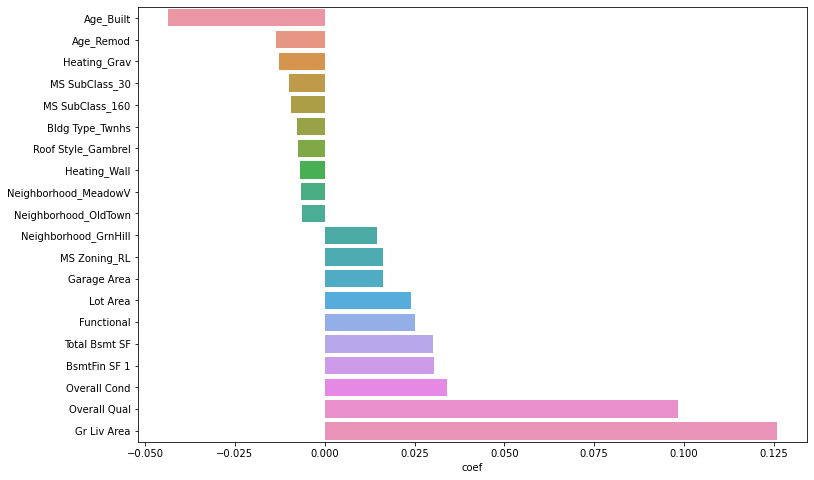

In [97]:
# check the top 20 coefficients
top20_coef = pd.DataFrame(pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)]), columns=["coef"])

plt.figure(figsize=(12,8))
sns.barplot(y=top20_coef.index, x="coef",data=top20_coef);

- Unsurpisingly, the total living area above ground and the overall quality are the most important features for this model, followed by the age of the house
- Many of the area features also do seem to be important. Maybe combining some of these features could increase the performance of my model => I will try to engineer some additional features to the lasso regression model

### 5.7 Lasso Regression (with Hyperparameter Tuning and Additional Feature Engineering)

In [98]:
# original df
df_add_train = pd.read_csv('../datasets/train.csv')
df_add_test = pd.read_csv('../datasets/test.csv')

df_add_train['set'] = 'train'
df_add_test['set'] = 'test'

df_add = pd.concat([df_add_train,df_add_test])

In [99]:
# data cleansing

df_add['Bsmt Exposure'] = np.where((df_add['Bsmt Exposure'].isnull()) & (df_add['Bsmt Qual'].notnull()), "No", df_add['Bsmt Exposure'])
df_add.drop(index = 1147, inplace = True)
df_add = df_add.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))
df_add = df_add[df_add['Garage Yr Blt']<=2010]


string_feat = ['Id', 'PID', 'MS SubClass']
for feat in string_feat:
    df_add[feat] = df_add[feat].apply(str)

df_add = df_add.replace(ordinal_dict)
df_add.drop(index = [960,1885], inplace = True)


df_add['Age_Built'] = df_add['Yr Sold'] + (df_add['Mo Sold']/12) - df_add['Year Built']
df_add['Age_Remod'] = df_add['Yr Sold'] + (df_add['Mo Sold']/12) - df_add['Year Remod/Add']
df_add['Age_Garage'] = df_add.apply(lambda row: convert_garage(row), axis=1)
df_add['Garage Yr Blt'] = np.where(df_add['Age_Garage']>1000, df_add['Year Built'], df_add['Garage Yr Blt'])
df_add['Age_Garage'] = np.where(df_add['Age_Garage']>1000, df_add['Age_Built'], df_add['Age_Garage'])


df_add['seasons'] = df_add['Mo Sold'].map({1:'winter',
                                   2:'winter',
                                   3: 'spring',
                                   4: 'spring',
                                   5: 'summer',
                                   6: 'summer',
                                   7: 'summer',
                                   8: 'autumn',
                                   9: 'autumn',
                                   10: 'autumn',
                                   11: 'winter',
                                   12: 'winter' 
                                  })

df_add['is_2008'] = df_add['Yr Sold'].apply(lambda x: 1 if x==2008 else 0)


In [100]:
df_add.shape

(2925, 87)

- I will try to create some interaction terms for features that are referring to the same part of the house (i.e. a Rating feature)
- I will also combine the bathrooms, the total square ft of the house, and the porch square ft to see if this can help improve my model

In [101]:
# I will try to create interaction terms for features that are referring to the same part of the house
df_add['Overall Rating'] = df_add['Overall Cond']* df_add['Overall Qual']
df_add['Exter Rating'] = df_add['Exter Cond'] * df_add['Exter Qual']
df_add['Bsmt Rating'] = df_add['Bsmt Cond'] * df_add['Bsmt Exposure'] * df_add['Bsmt Qual'] 
df_add['Garage Rating'] = df_add['Garage Cond'] * df_add['Garage Qual'] * df_add['Garage Finish']
df_add['Kitchen Rating'] = df_add['Kitchen AbvGr'] * df_add['Kitchen Qual']
df_add['Fireplace Rating'] = df_add['Fireplace Qu'] * df_add['Fireplaces']
df_add['Pool Rating'] = df_add['Pool Area'] * df_add['Pool QC']


# Combine bathrooms
df_add['Total_baths'] = (0.5 * df_add['Half Bath']) + df_add['Full Bath'] + (0.5 * df_add['Bsmt Half Bath']) + df_add['Bsmt Full Bath']


# Combine SF
df_add["SF_total"] = df_add["Gr Liv Area"] + df_add["Total Bsmt SF"]
df_add['Porch_SF_total'] = df_add['Wood Deck SF'] + df_add['Open Porch SF'] + df_add['Enclosed Porch'] + df_add['3Ssn Porch'] + df_add['Screen Porch']



In [102]:
df_add_train = df_add[df_add['set']=='train']

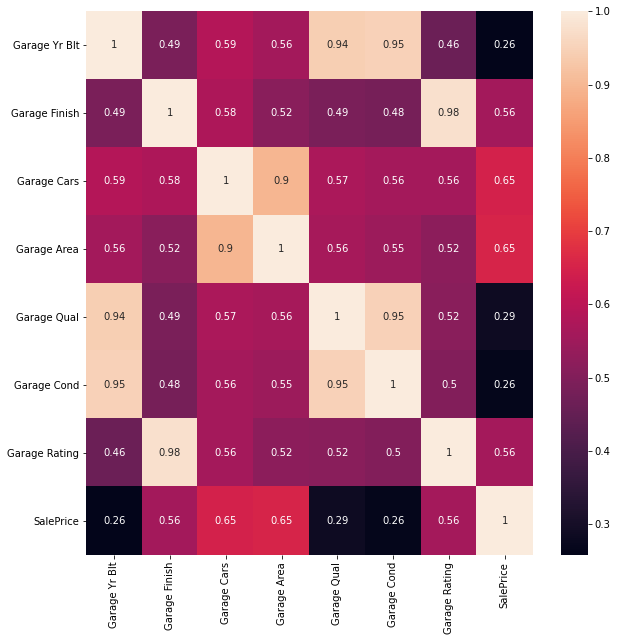

In [103]:
# display garage feature correlation to see multicollinearity
plt.figure(figsize=(10,10))
sns.heatmap(df_add_train[['Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond','Garage Rating', 'SalePrice']].corr(),annot=True);

In [104]:
# check for highly correlated columns
np.abs(df_add_train.corr()).unstack().sort_values(ascending=False).drop_duplicates()[:20]

Porch_SF_total    Porch_SF_total    1.000000
Year Built        Age_Built         0.999075
Year Remod/Add    Age_Remod         0.998092
Garage Rating     Garage Finish     0.977155
Pool Rating       Pool Area         0.967015
Fireplace Rating  Fireplaces        0.960076
Bsmt Exposure     Bsmt Rating       0.951421
Garage Cond       Garage Yr Blt     0.950756
                  Garage Qual       0.950486
Garage Yr Blt     Garage Qual       0.943534
Pool Rating       Pool QC           0.928090
Fireplace Rating  Fireplace Qu      0.911308
Pool QC           Pool Area         0.898498
Garage Cars       Garage Area       0.897180
SF_total          Gr Liv Area       0.863202
Fireplace Qu      Fireplaces        0.860824
Exter Qual        Exter Rating      0.832322
SF_total          SalePrice         0.826023
Total Bsmt SF     SF_total          0.815757
TotRms AbvGrd     Gr Liv Area       0.812159
dtype: float64

In [105]:
# drop highly correlated columns
df_add.drop(['PID',
         'Yr Sold',
         'Year Built',
         'Year Remod/Add',
         'Garage Finish',
         'Garage Yr Blt',
         'Garage Cond',
         'Garage Cars',
         'Pool QC',
         'Pool Area',
         'Gr Liv Area',
         'Fireplace Qu',
         'Fireplaces',
         'Exter Qual',
         'Total Bsmt SF',
         'Bsmt Exposure',
        ], axis= 1, inplace=True)

df_add_train = df_add[df_add['set']=='train']

In [106]:
# save a copy of final df  
df_copy = df_add.copy()

In [107]:
#log transform sale price
df_add['SalePrice'] = np.log1p(df_add['SalePrice'])

#get dummies for categorical features
df_add = pd.get_dummies(df_add.drop(['set','Id'],axis=1), drop_first=True)

#split data
df_add_train = df_add[:2047]
df_add_test = df_add[2047:].drop('SalePrice',axis=1)

In [108]:
X_add = df_add_train.drop('SalePrice', axis = 1)
y_add = df_add_train['SalePrice']

# train test split
Xadd_train, Xadd_test, yadd_train, yadd_test = train_test_split(X_add, y_add, test_size=0.33, random_state=103)

In [109]:
# standardize data 
sc_add = StandardScaler()

Xadd_train = sc_add.fit_transform(Xadd_train)
Xadd_test = sc_add.transform(Xadd_test)
test_submission_add = sc_add.transform(df_add_test)

In [110]:
# find optimal alpha value for lasso
l_alphas = np.logspace(-3, 0, 100)

lasso_cv_add = LassoCV(alphas=l_alphas, cv=5, max_iter=70000)
lasso_cv_add.fit(Xadd_train, yadd_train);

In [111]:
# instantiate lasso with optimal alpha value
lasso_add = Lasso(alpha = lasso_cv_add.alpha_ )

# fit lasso model
lasso_add.fit(Xadd_train, yadd_train)

Lasso(alpha=0.0032745491628777285)

In [112]:
# compare train, test, cv scores

display_r2(lasso_add, Xadd_train, yadd_train, Xadd_test, yadd_test)

Train Score:  0.92539
Test Score:  0.9258388
Cross Val Score: 0.9245003


- This model is a good fit. It performs similarly well on the train, test, and cv data

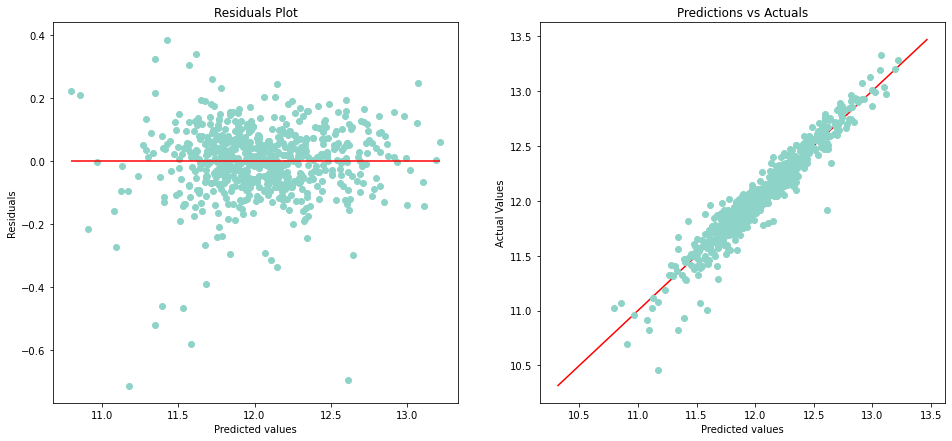

In [113]:
plot_pred(lasso_add, Xadd_test, yadd_test)

- The graphs are very similar to the lasso and ridge with hyperparameter tuning

In [114]:
add_model('Lasso with Additional Feature Engineering', lasso_add, Xadd_test, yadd_test)

,RMSE,R2 Score
Baseline,4.039813e-01,-1.468947e-03
LinReg Default,1.862285e+11,-4.393418e+19
Ridge Default,1.375318e-01,9.032528e-01
Lasso Default,4.039333e-01,-1.468900e-03
Ridge with Hyperparameter Tuning,1.180445e-01,9.217659e-01
Lasso with Hyperparameter Tuning,1.108917e-01,9.241969e-01
Lasso with Additional Feature Engineering,1.100136e-01,9.258388e-01


- There was a slight improvement for the RMSE and R2 score compared to the original lasso with hyperparamter tunning model, however, the models performed very similarly

In [115]:
coef_add = pd.Series(lasso_add.coef_, index = X_add.columns)

print("Lasso picked " + str(sum(coef_add != 0)) +  
      " variables and eliminated the other " +  str(sum(coef_add == 0)) + " variables")

Lasso picked 88 variables and eliminated the other 139 variables


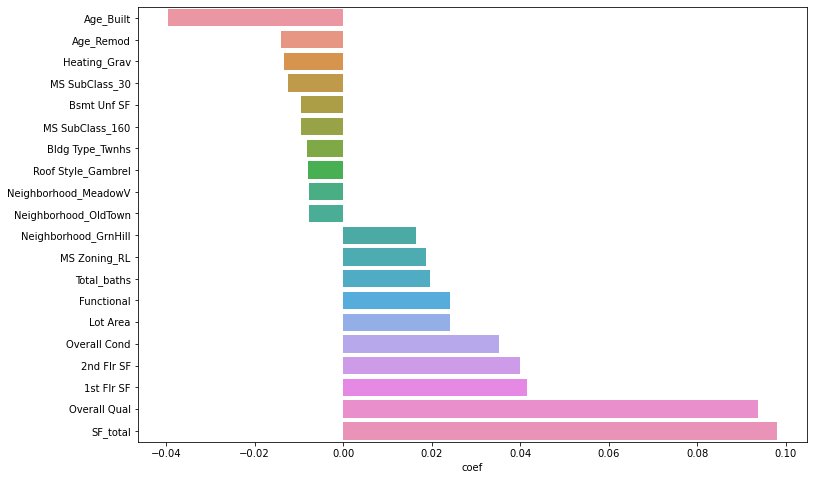

In [116]:
# check the top 20 coefficients
top20_coefadd = pd.DataFrame(pd.concat([coef_add.sort_values().head(10),coef_add.sort_values().tail(10)]), columns=["coef"])

plt.figure(figsize=(12,8))
sns.barplot(y=top20_coefadd.index, x="coef",data=top20_coefadd);

- The total SF (which is very similar to Gr liv area), overall quality, and age features are still the most important features
- However, interestingly, the 1st floor SF, 2nd floor SF, overall condition, and Lot Area are much more important in this model
- This model is more balanced in terms of feature importance, as the previous lasso model has a huge emphasis on Gr Liv Area compared to every other feature, which means the price of the house is largely dependent on the above ground area and any outlier for this feature would impact the predicted price a lot 

## 6. Kaggle Submissions

I am going to submit both the lasso model with hyperparameter tuning, and the lasso model with hyperparamter tuning and additional feature engineering to kaggle to see which model performs better on the kaggle dataset

In [117]:
#Lasso with hyperparameter tuning

lasso1_pred = pd.DataFrame(lasso_tuned.predict(test_submission), index = test['Id'], columns = ['SalePrice'])
lasso1_pred['SalePrice'] = np.expm1(lasso1_pred['SalePrice'])
lasso1_pred.to_csv('../kaggle_submission/lasso_tuned.csv')

In [118]:
# Lasso with hyperparameter tuning and feature engineering

lasso2_pred = pd.DataFrame(lasso_add.predict(test_submission_add), index = test['Id'], columns = ['SalePrice'])
lasso2_pred['SalePrice'] = np.expm1(lasso2_pred['SalePrice'])
lasso2_pred.to_csv('../kaggle_submission/lasso_feat_eng.csv')


## 7. Conclusions and Recommendations

In [119]:
# calculate RMSE in USD
rmse_final = ((metrics.mean_squared_error(np.expm1(y_test),np.expm1(lasso_add.predict(Xadd_test))))**0.5)
print(f'RMSE: {round(rmse_final,2)} USD')

#print R2 final
r2_score = lasso_add.score(Xadd_test, yadd_test)
print(f'R2 score: {round(r2_score,5)}')

RMSE: 19857.76 USD
R2 score: 0.92584


In [120]:
# calculate baseline RMSE in USD
rmse_baseline =(metrics.mean_squared_error(np.expm1(y_test),np.expm1(baseline['yhat'])))**0.5
print(f'RMSE (Baseline): {round(rmse_baseline,2)} USD')

RMSE (Baseline): 82556.99 USD


The model I have chosen to use as my production model is the lasso regression model with hyperparameter tuning and additional feature engineering. This model was a good fit and performed well on my test data set, with an R2 score of 0.92584 and an RMSE of 19857.76 USD.

For comparison, the baseline RMSE using the mean sale price from the training data set is 82556.99 USD.

### 7.1 Coefficient Analysis

In [121]:
coef_unscaled = (lasso_add.coef_ * sc_add.scale_) + sc_add.mean_
coef_unscaled = pd.DataFrame([X_add.columns, coef_unscaled]).T.rename(columns={0:'feature',1:'coef'})

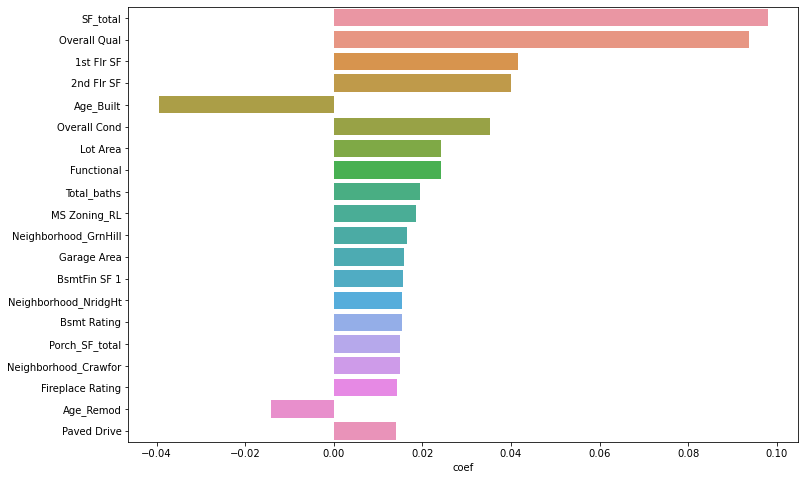

In [122]:
top20 = pd.DataFrame(coef_add[abs(coef_add).sort_values(ascending=False).head(20).index], columns = ['coef'])

plt.figure(figsize=(12,8))
sns.barplot(y=top20.index, x="coef",data=top20);

- From looking at the top 20 coefficients that contribute to my lasso model, the total area of the house (living area and basement combined), overall quality, 1st floor and 2nd floor area, the age of the house, and overall condition are the most important features when determining the price of a house
- There are also certain neighborhoods that seem to have a big impact on the price of the house, namely Green hills, Northridge Heights, and Crawford. 
- Additionally, the Age_remod (i.e. the number of years since the house has been remodelled) also has an impact on the sale price. This means houses that are newly renovated do sell at a higher price. By looking at the top 20 coefficients, there are many features that can be remodelled or improved to maximize the returns on the property. For example, increasing the size of te porch, improving the quality of the fireplace (or increasing the number of fireplaces), and upgrading the driveway to paved from gravel could increase the value of the house. 

### 7.2 Statistical Inference

- For the purpose of statistical inference, I will fit an OLS model using my final dataframe (with additional feature engineeering). 
- As I am not using this model to predict house prices, I will use the full dataframe (instead of doing a train test split). I can use this model to derive estimates for how particular features impact the sale price of the house in USD amounts

In [123]:
# drop the ID and Set features from data set
df_copy = df_copy[df_copy['set'] == 'train'].drop(['Id','set'], axis=1)

# get dummies for categorical variables
df_copy = pd.get_dummies(df_copy, drop_first=True)

# fit OLS model
X_sm = df_copy.drop('SalePrice', axis =1).values
X_sm = sm.add_constant(X_sm)
y_sm = df_copy['SalePrice']


model = sm.OLS(y_sm, X_sm)
model = model.fit()

In [124]:
model.rsquared

0.9328309635204105

- The R2 score for my OLS model is 0.9328 => I am comfortable using this model to infer how explanatory variables may affect the house prices in this dataset.

In [125]:
param = pd.DataFrame(model.params, columns=['coef'])
param['pvalues'] = model.pvalues

In [126]:
# create dataframe of coefficients
param_name = list(df_copy.drop('SalePrice', axis =1))
param_name.insert(0,'Const')
param['feature_name'] = param_name

In [127]:
param_sig = param[param['pvalues']<0.05]
len(param_sig)

59

- Of the 218 featues present in the dataframe, the OLS model has found 59 variables to be statistically significant at a 95% confidence level

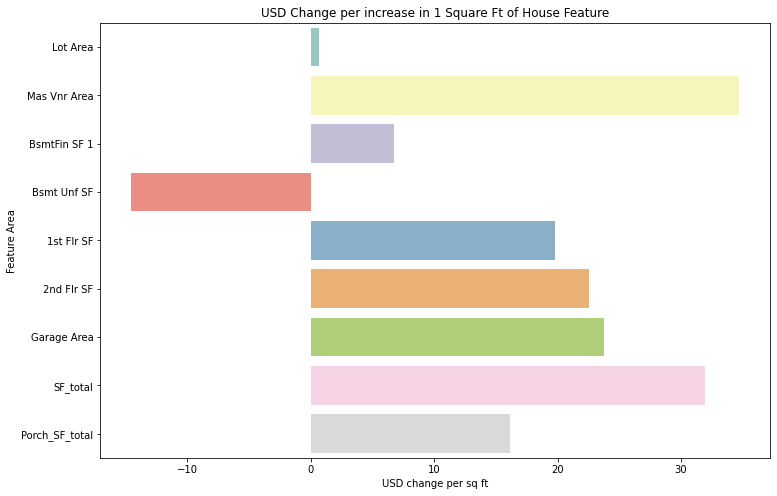

In [128]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y = 'feature_name', x = 'coef',
            data = param_sig[(param_sig['feature_name'].str.contains('Area')) | (param_sig['feature_name'].str.contains('SF'))])
ax.set_xlabel('USD change per sq ft')
ax.set_ylabel('Feature Area')
ax.set_title('USD Change per increase in 1 Square Ft of House Feature');

- From the graph, it can be seen that if all other features are constant a 1 square ft increase in the masonry veneer area would lead to a 35USD increase in the price of the house, and a 1 square ft increase in the total area would lead to a 33USD increase in the price of the house 
- Every square ft of unfinished basement space decreases the price of the house by 17USD, whereas every square ft of the finished basement area increases the price of the house by 7 USD. If Opendoors purchases property with unfinished basement area, this is a feature they should complete furnishing before reselling the property
- Whereas some of these features are fixed (such as the lot area, total SF of the 1st floor and 2nd floor), reconstructing the porch area or garage area where possible could increase the value of the house

In [129]:
feat = ['Age_Built','TotRms AbvGrd', 'Total_baths'] 

for i in feat:
    print(f"If all other features remain constant, a 1 unit increase in {i} will change the selling price of a house by {round(float(param_sig[param_sig['feature_name']== i]['coef']),2)} USD")
    print("")


If all other features remain constant, a 1 unit increase in Age_Built will change the selling price of a house by -339.75 USD

If all other features remain constant, a 1 unit increase in TotRms AbvGrd will change the selling price of a house by 1717.96 USD

If all other features remain constant, a 1 unit increase in Total_baths will change the selling price of a house by 1836.91 USD



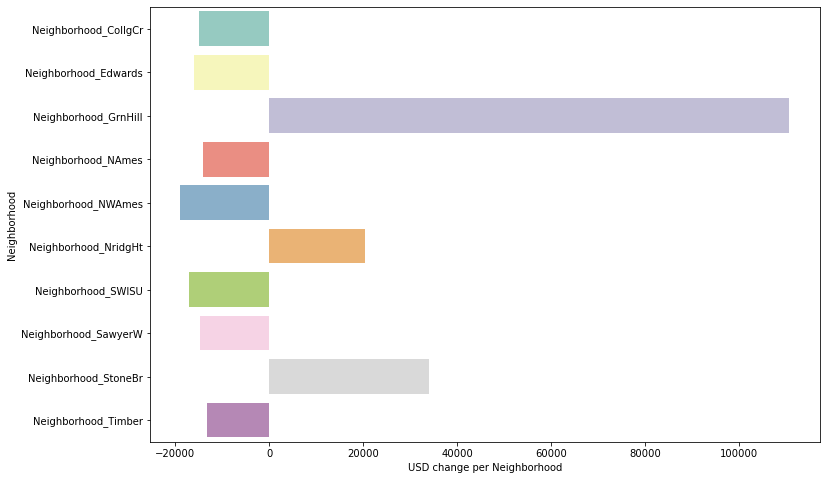

In [130]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y = 'feature_name', x = 'coef',
            data = param_sig[param_sig['feature_name'].str.contains('Neighborhood')])
ax.set_xlabel('USD change per Neighborhood')
ax.set_ylabel('Neighborhood');

On average, if all other features are constant:
- a house in Green Hills will sell for 110K USD more than a house in another neighborhood
- a house in Stone Brook will sell for 34K USD more than a house in another neighborhood
- a house in Northridge heigh will sell for 20K USD more than a house in another neighborhood

In contrast, if all other features are constant:
- a house in Northwest Ames will sell for 19K USD less than a house in another neighborhood
- A house in South & West of Iowa State University will sell for 17K USD less thann a house in another neighborhood
- A house in Edwards will sell for 16K USD less than a house in another neighborhood

In [131]:
dwelling = {20:    "1-STORY 1946 & NEWER ALL STYLES",
            30:    "1-STORY 1945 & OLDER",
            40:    "1-STORY W/FINISHED ATTIC ALL AGES",
            45:    "1-1/2 STORY - UNFINISHED ALL AGES",
            50:    "1-1/2 STORY FINISHED ALL AGES",
            60:    "2-STORY 1946 & NEWER",
            70:    "2-STORY 1945 & OLDER",
            75:    "2-1/2 STORY ALL AGES",
            80:    "SPLIT OR MULTI-LEVEL",
            85:    "SPLIT FOYER",
            90:    "DUPLEX - ALL STYLES AND AGES",
            120:   "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
            150:   "1-1/2 STORY PUD - ALL AGES",
            160:   "2-STORY PUD - 1946 & NEWER",
            180:   "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
            190:    "2 FAMILY CONVERSION - ALL STYLES AND AGES"}

In [132]:
subclass_MS = param_sig[param_sig['feature_name'].str.contains('MS')].copy()
subclass_MS['feature_name'] = subclass_MS['feature_name'].apply(lambda x: int(x.split('_')[1]))
subclass_MS['Dwelling Type'] = subclass_MS['feature_name'].map(dwelling)

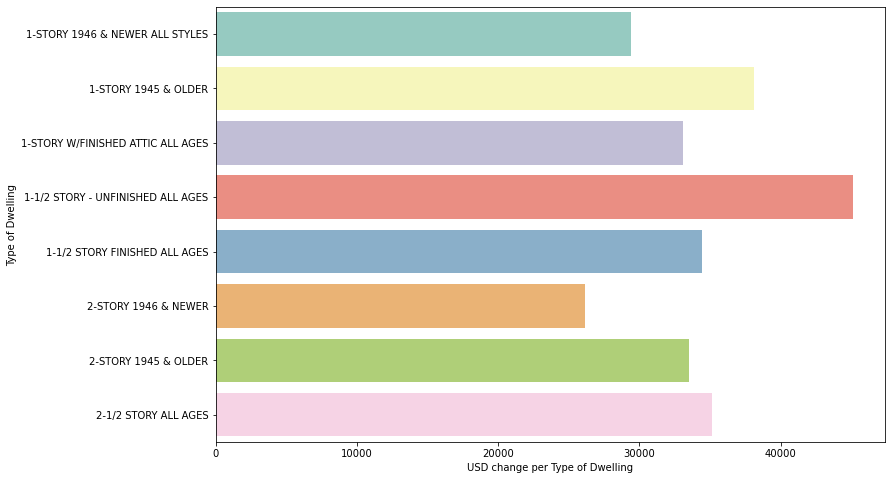

In [133]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y = 'Dwelling Type', x = 'coef',
            data = subclass_MS)
ax.set_xlabel('USD change per Type of Dwelling')
ax.set_ylabel('Type of Dwelling');

In [134]:
subclass_pct = pd.DataFrame(train['MS SubClass'].value_counts(normalize=True)).reset_index()
subclass_MS.merge(subclass_pct, left_on='feature_name', right_on='index').drop('index',axis=1)

,coef,pvalues,feature_name,Dwelling Type,MS SubClass
0,29379.785790,0.011215,20,1-STORY 1946 & NEWER ALL STYLES,0.375427
1,38095.118760,0.001611,30,1-STORY 1945 & OLDER,0.049244
2,33092.942676,0.046542,40,1-STORY W/FINISHED ATTIC ALL AGES,0.001950
3,45145.274379,0.023238,45,1-1/2 STORY - UNFINISHED ALL AGES,0.005363
4,34458.388209,0.011471,50,1-1/2 STORY FINISHED ALL AGES,0.096538
5,26162.994808,0.042331,60,2-STORY 1946 & NEWER,0.192101
6,33520.106187,0.010647,70,2-STORY 1945 & OLDER,0.043881
7,35148.654726,0.036332,75,2-1/2 STORY ALL AGES,0.007801


- 38% of the houses sold in Ames are 1-Story 1946 and Newer style houes. If all other features are constant, this type of dwelling will sell for 29K USD higher than other types of dwellings
- 19% of the houses sold in Ames are 2-Story 1946 & Newer houses. If all other features are constant, this type of dwelling will sell for 26K USD higher than other types of dwellings
- The type of dwelling that will increase the price of the house the most if all other features are constant are 1-1/2 Story Unfinished houses, which increase the price of the house by 45K compared to other types of dwellings. Unfortunately, only 0.5% of houses are of this dwelling type.

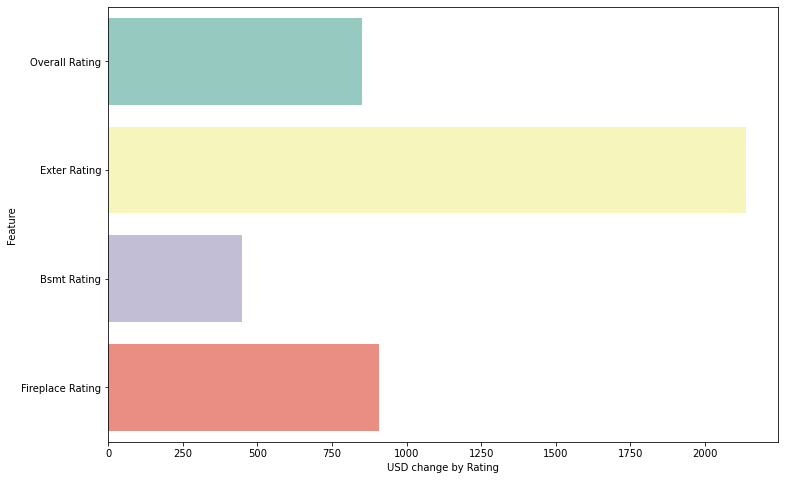

In [135]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y = 'feature_name', x = 'coef',
            data = param_sig[(param_sig['feature_name'].str.contains('Rating'))])
ax.set_xlabel('USD change by Rating')
ax.set_ylabel('Feature');

- The exterior rating measures the quality and condition of the material on the exterior of the property. As the rating increases by 1 unit, the value of the house will increase by 2.1K USD if all other features are constant.
- The fireplace rating measures the number of fireplaces and the quality of the fireplaces. Increasing the fireplace rating by 1 unit will incrase the value of the house by 908USD, if all other features are constant.
- The basement rating measures the height (quality) of the basement, the general condition of the basement, and the exposure of the basement. Increasing the rating by 1 unit will increase the value of the house by 450 USD, if all other features are constant
- The overall rating measures the overall material and finish of the house, and the overall condition of the house. Increasing the rating by 1 unit will increase the value of the house by 850 USD, if all other featues are constant.

### 7.3 Business Recommendations

The purpose of this project was to build a linear regression model that could predict the selling price of houses across Ames, Iowa. The final lasso regression model with hyperparameter tuning and additional feature engineering successfully predicted selling prices with an R2 score of 0.92584 and an RMSE of 19857.76 USD. Compared to the baseline RMSE of 82556.99 USD this is a significant improvement.

Additionally, I would recommend Opendoor to focus on the following neighborhoods and types of dwellings:

- Neighborhoods: I would recommend purchasing properties in Green Hills, Stone Brook, and Northridge Height. If all other features are constant:
> - A house in Green Hills will sell for 110K USD more than a house in another neighborhood
> - A house in Stone Brook will sell for 34K USD more than a house in another neighborhood
> - A house in Northridge Height will sell for 20K USD more than a house in another neighborhood

- Types of dwellings: While a 1-1/2 Story Unfinished house will sell for 45K USD more than another type of dwelling if all other features are constant, this type of property is not very common and only 0.05% of houses sold between 2006 and 2010 are of this type. Therefore, I would recommend focusing on the following two types of dwellings:
> - 1-Story 1946 and Newer Style Houses. 38% of the houses sold in Ames between 2006 and 2010 are of this type. If all other features are constant, this type of dwelling will sell for 29K USD higher than other types of dwellings
> - 2-Story 1946 & Newer houses. 19% of the houses sold in Ames betweeb 2006 and 2010 are of this type. If all other features are constant, this type of dwelling will sell for 26K USD higher than other types of dwellings

Finally, some other features that Opendoor may find beneficial to renovate before re-listing properties are:
- If Opendoor is able to increase the area or build additional rooms in an unfinished property:
> - In general, if all other features are constant, increasinng the total living area (including the basement) would increase the price of the house by 33USD per square ft.
> - In particular, I would ensure that the basement is complete as an unfinished basement does decrease the price of the house by 17USD per square ft. In contrast, every square ft of finished basement space increases the value of the house by 7 USD if all other features are constant.
> - Additionally, increasing the total number of rooms would increase the selling price of the house by 1.7K USD per room, and increase the total number of bathrooms would increase the selling price by 1.8K USD per room.
-  Lastly, a quick win where possible would be to increase the number of fireplaces, or the quality of the fireplace. From all the miscellanious features (such as the pool, kitchen, fence, etc), the fireplace is the only feature with a statistical significance at a 95% confidence level. Increasing the rating of the fireplace by 1 unit will increase the value of the house by over 900USD, if all other features are constant.